# Univariate Relationships with the Market in-context
I rerun the univariate regressions from 1.0.Univariate_Modelling however include market effects in-context.
I include this mostly for completeness, we expect market effects to be largely independent and reaffirm this by seeing not much impact on the conclusions from the previous file. The code is the same bar a few additional lines, and I leave out my comments.

In [7]:
import warnings
import pandas as pd
import statsmodels.api as sm
from utils import *
from statsmodels.api import OLS
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
df = pd.read_parquet('data/market_data.parquet')
df['date'] = pd.to_datetime(df['jdate'])
df['me_rank'] = df.groupby('date')['me'].rank(ascending=False)
sp500 = pd.read_parquet('sp500_index_data.parquet')
sp500['date'] = pd.to_datetime(sp500['caldt'])
sp500.set_index('date', inplace=True)
# Calculate compounded returns for each month
monthly_sp500 = sp500['vwretx'].resample('M').apply(lambda x: (1 + x).prod() - 1).reset_index()
#Convert to monthly return by end of month (each date is the end of a month)
monthly_sp500 = monthly_sp500[['date', 'vwretx']]
df = df.merge(monthly_sp500, on='date')

,mthcaldt,permno,sharetype,securitytype,securitysubtype,usincflg,issuertype,primaryexch,conditionaltype,tradingstatusflg,...,ffyear,jdate,szport,bmport,posbm,nonmissport,beme,date,me_rank,vwretx
0,1988-07-29,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,1988,1988-07-31,S,H,1.0,1.0,1.207618,1988-07-31,3942.0,-0.007362
1,1988-08-31,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,1988,1988-08-31,S,H,1.0,1.0,1.207618,1988-08-31,3867.0,-0.037428
2,1988-09-30,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,1988,1988-09-30,S,H,1.0,1.0,1.207618,1988-09-30,3855.0,0.040077
3,1988-10-31,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,1988,1988-10-31,S,H,1.0,1.0,1.207618,1988-10-31,3778.0,0.023476
4,1988-11-30,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,1988,1988-11-30,S,H,1.0,1.0,1.207618,1988-11-30,3688.0,-0.019856


In [10]:
df['ann_ret_shifted'] = df.groupby('permno')['cumretx'].shift(-12)
df['ann_ret'] = df['ann_ret_shifted'] / df['cumretx'] - 1

df['momentum_shifted'] = df.groupby('permno')['cumretx'].shift(1)
df['momentum'] = df['momentum_shifted'] / df.groupby('permno')['cumretx'].shift(13) - 1
df = df.drop(columns=['ann_ret_shifted', 'momentum_shifted'])

,mthcaldt,permno,sharetype,securitytype,securitysubtype,usincflg,issuertype,primaryexch,conditionaltype,tradingstatusflg,...,szport,bmport,posbm,nonmissport,beme,date,me_rank,vwretx,ann_ret,momentum
0,1988-07-29,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,S,H,1.0,1.0,1.207618,1988-07-31,3942.0,-0.007362,0.005548,NaN
1,1988-08-31,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,S,H,1.0,1.0,1.207618,1988-08-31,3867.0,-0.037428,0.246631,NaN
2,1988-09-30,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,S,H,1.0,1.0,1.207618,1988-09-30,3855.0,0.040077,0.242997,NaN
3,1988-10-31,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,S,H,1.0,1.0,1.207618,1988-10-31,3778.0,0.023476,0.280323,NaN
4,1988-11-30,10001,NS,EQTY,COM,Y,CORP,Q,RW,A,...,S,H,1.0,1.0,1.207618,1988-11-30,3688.0,-0.019856,0.330863,NaN


In [11]:
df = df[df['me_rank'].shift(1) < 600]

In [12]:
beme_df = df[['date', 'permno', 'beme', 'ann_ret', 'vwretx']]
counter = 0
number_of_firms = len(beme_df['permno'].unique())
for firm in beme_df['permno'].unique():
    counter += 1
    print(f'Processing firm {counter / number_of_firms * 100:.2f}%', end='\r')
    subset = beme_df[beme_df['permno'] == firm].sort_values('date').dropna(subset=['beme', 'ann_ret', 'vwretx']).reset_index()
    for i in range(12 * 5 + 1, len(subset)):
        X = subset.loc[i - 12 * 5:i - 1, ['beme', 'vwretx']]
        X = sm.add_constant(X)
        y = subset.loc[i - 12 * 5:i - 1, 'ann_ret']
        
        model = sm.OLS(y, X).fit()
        
        # Assign the alpha and beta values to beme_df, ensuring proper indexing by both permno and date
        beme_df.loc[(beme_df['permno'] == firm) & (beme_df['date'] == subset.iloc[i]['date']), 'beme_alpha'] = model.params[0]
        beme_df.loc[(beme_df['permno'] == firm) & (beme_df['date'] == subset.iloc[i]['date']), 'beme_beta'] = model.params[1]
        beme_df.loc[(beme_df['permno'] == firm) & (beme_df['date'] == subset.iloc[i]['date']), 'market_beta'] = model.params[2]

4846essing firm 100.00%


,date,permno,beme,ann_ret,vwretx,beme_alpha,beme_beta,market_beta
636,1964-08-31,10006,0.778226,-0.019139,-0.016279,NaN,NaN,NaN
637,1964-09-30,10006,0.778226,-0.098498,0.029022,NaN,NaN,NaN
638,1964-10-31,10006,0.778226,-0.029525,0.007657,NaN,NaN,NaN
639,1964-11-30,10006,0.778226,-0.017443,-0.004660,NaN,NaN,NaN
640,1964-12-31,10006,0.778226,0.121360,0.003802,NaN,NaN,NaN


In [29]:
beme_df['beme_beta'] = beme_df.groupby('permno')['beme_beta'].shift(12)
beme_df['beme_alpha'] = beme_df.groupby('permno')['beme_alpha'].shift(12)
beme_df['market_beta'] = beme_df.groupby('permno')['market_beta'].shift(12)
beme_df['predict'] = beme_df['beme_alpha'] + beme_df['beme_beta'] * beme_df['beme'] + beme_df['market_beta'] * beme_df['vwretx']

,date,permno,beme,ann_ret,vwretx,beme_alpha,beme_beta,market_beta,predict
636,1964-08-31,10006,0.778226,-0.019139,-0.016279,NaN,NaN,NaN,NaN
637,1964-09-30,10006,0.778226,-0.098498,0.029022,NaN,NaN,NaN,NaN
638,1964-10-31,10006,0.778226,-0.029525,0.007657,NaN,NaN,NaN,NaN
639,1964-11-30,10006,0.778226,-0.017443,-0.004660,NaN,NaN,NaN,NaN
640,1964-12-31,10006,0.778226,0.121360,0.003802,NaN,NaN,NaN,NaN


<Axes: xlabel='date'>

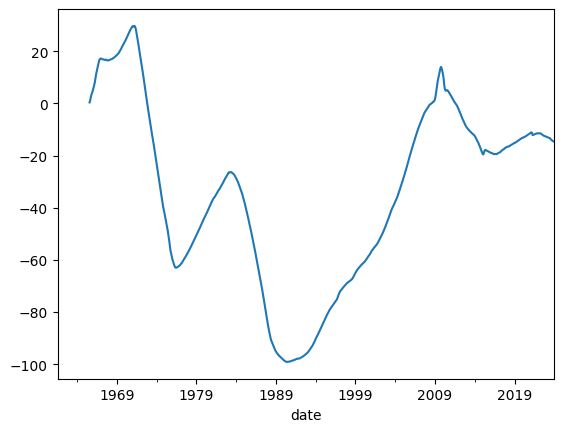

In [39]:
x = beme_df.groupby('date')['market_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

<Axes: xlabel='date'>

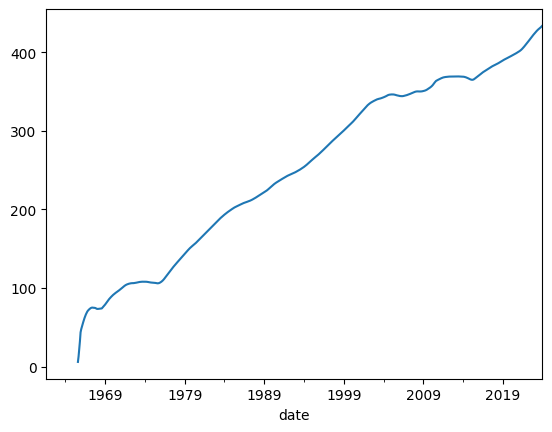

In [30]:
x = beme_df.groupby('date')['beme_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

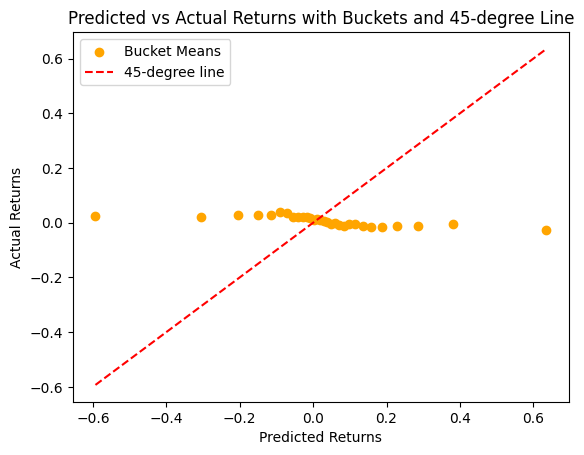

In [31]:
plot_actual_vs_predicted(beme_df, 'predict', 'ann_ret')

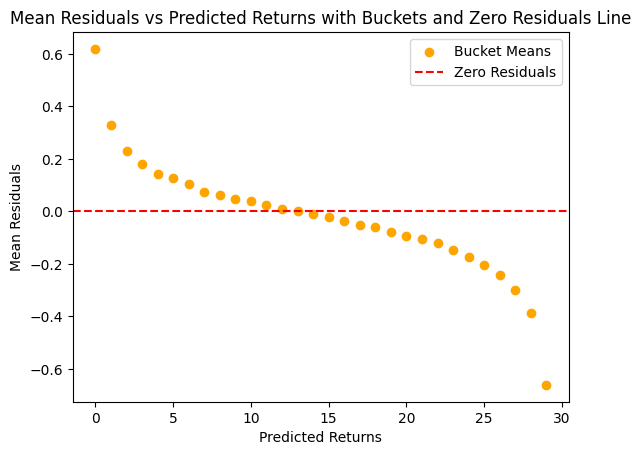

In [32]:
plot_residuals(beme_df, 'predict', 'ann_ret')

In [17]:
momentum_df = df[['date', 'permno', 'momentum', 'ann_ret', 'vwretx']]
counter = 0
number_of_firms = len(momentum_df['permno'].unique())
for firm in momentum_df['permno'].unique():
    counter += 1
    print(f'Processing firm {counter / number_of_firms * 100:.2f}%', end='\r')
    subset = momentum_df[momentum_df['permno'] == firm].sort_values('date').dropna(subset=['momentum', 'ann_ret', 'vwretx']).reset_index()
    for i in range(12 * 5 + 1, len(subset)):
        X = subset.loc[i - 12 * 5:i - 1, ['momentum', 'vwretx']]
        X = sm.add_constant(X)
        y = subset.loc[i - 12 * 5:i - 1, 'ann_ret']
        
        model = sm.OLS(y, X).fit()
        
        # Assign the alpha and beta values to beme_df, ensuring proper indexing by both permno and date
        momentum_df.loc[(momentum_df['permno'] == firm) & (momentum_df['date'] == subset.iloc[i]['date']), 'momentum_alpha'] = model.params[0]
        momentum_df.loc[(momentum_df['permno'] == firm) & (momentum_df['date'] == subset.iloc[i]['date']), 'momentum_beta'] = model.params[1]
        momentum_df.loc[(momentum_df['permno'] == firm) & (momentum_df['date'] == subset.iloc[i]['date']), 'market_beta'] = model.params[2]
momentum_df.head()

,date,permno,momentum,ann_ret,vwretx,momentum_alpha,momentum_beta,market_beta
636,1964-08-31,10006,NaN,-0.019139,-0.016279,NaN,NaN,NaN
637,1964-09-30,10006,NaN,-0.098498,0.029022,NaN,NaN,NaN
638,1964-10-31,10006,NaN,-0.029525,0.007657,NaN,NaN,NaN
639,1964-11-30,10006,NaN,-0.017443,-0.004660,NaN,NaN,NaN
640,1964-12-31,10006,NaN,0.121360,0.003802,NaN,NaN,NaN


In [33]:
momentum_df['momentum_beta'] = momentum_df.groupby('permno')['momentum_beta'].shift(12)
momentum_df['momentum_alpha'] = momentum_df.groupby('permno')['momentum_alpha'].shift(12)
momentum_df['market_beta'] = momentum_df.groupby('permno')['market_beta'].shift(12)
momentum_df['predict'] = momentum_df['momentum_alpha'] + momentum_df['momentum_beta'] * momentum_df['momentum'] + momentum_df['market_beta'] * momentum_df['vwretx']
momentum_df.head()

,date,permno,momentum,ann_ret,vwretx,momentum_alpha,momentum_beta,market_beta,predict
636,1964-08-31,10006,NaN,-0.019139,-0.016279,NaN,NaN,NaN,NaN
637,1964-09-30,10006,NaN,-0.098498,0.029022,NaN,NaN,NaN,NaN
638,1964-10-31,10006,NaN,-0.029525,0.007657,NaN,NaN,NaN,NaN
639,1964-11-30,10006,NaN,-0.017443,-0.004660,NaN,NaN,NaN,NaN
640,1964-12-31,10006,NaN,0.121360,0.003802,NaN,NaN,NaN,NaN


<Axes: xlabel='date'>

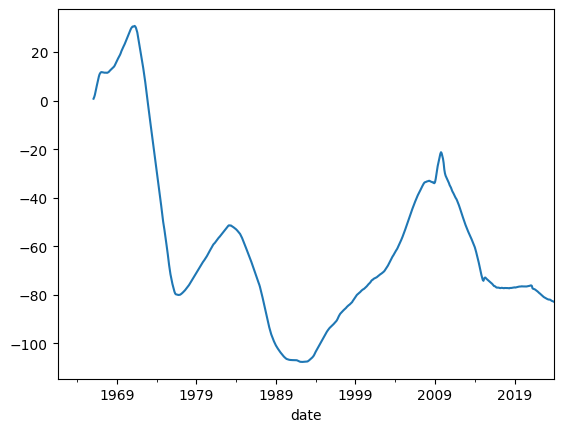

In [34]:
x = momentum_df.groupby('date')['market_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

<Axes: xlabel='date'>

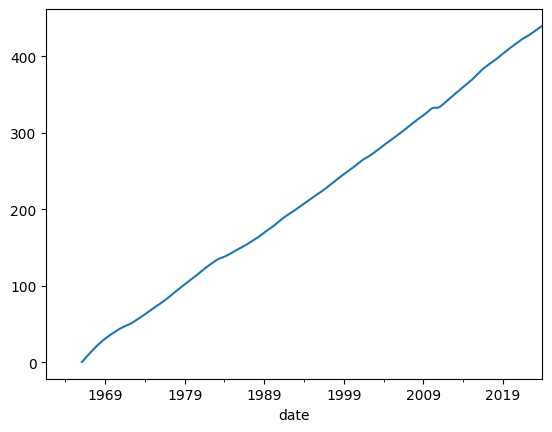

In [35]:
x = momentum_df.groupby('date')['momentum_beta'].mean()
cumulative_beta = (1 + x).cumsum()
cumulative_beta.plot()

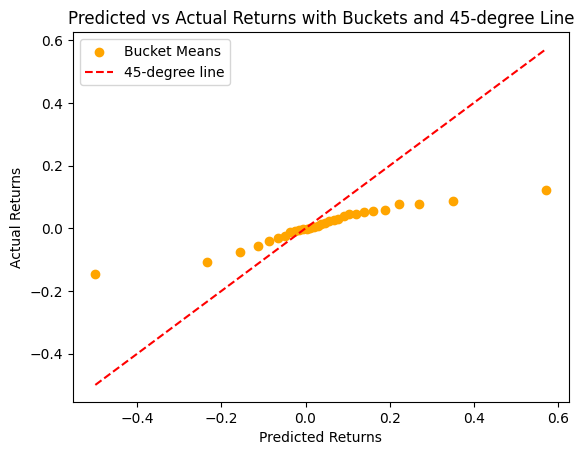

In [36]:
plot_actual_vs_predicted(momentum_df, 'predict', 'ann_ret')

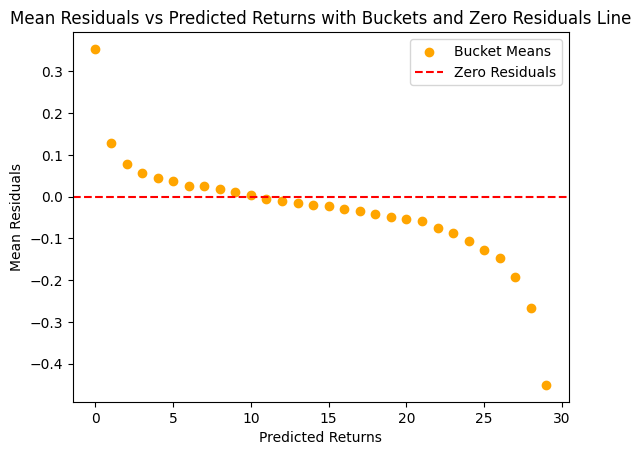

In [37]:
plot_residuals(momentum_df, 'predict', 'ann_ret')

In [38]:
df.to_parquet('data/regression_market_data.parquet')